In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost 
import lightgbm 

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading vader_lexicon: <urlopen error [WinError
[nltk_data]     10060] A connection attempt failed because the
[nltk_data]     connected party did not properly respond after a
[nltk_data]     period of time, or established connection failed
[nltk_data]     because connected host has failed to respond>


In [2]:
df_text = pd.read_csv("C:/Users/Gokul nath/Downloads/india-news-headlines.csv")
df_text.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [3]:
df_text.drop(0, inplace=True)
df_text.drop('headline_category', axis = 1, inplace=True)
df_text.head()

,publish_date,headline_text
1,20010102,Fissures in Hurriyat over Pak visit
2,20010102,America's unwanted heading for India?
3,20010102,For bigwigs; it is destination Goa
4,20010102,Extra buses to clear tourist traffic
5,20010102,Dilute the power of transfers; says Riberio


In [4]:
df_text["publish_date"] = pd.to_datetime(df_text["publish_date"],format='%Y%m%d')
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650969 entries, 1 to 3650969
Data columns (total 2 columns):
 #   Column         Dtype         
---  ------         -----         
 0   publish_date   datetime64[ns]
 1   headline_text  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 55.7+ MB


In [5]:
df_text.shape

(3650969, 2)

In [6]:
df_text.isnull().sum()

publish_date     0
headline_text    0
dtype: int64

In [7]:
df_text['headline_text'] = df_text.groupby(['publish_date']).transform(lambda x : ' '.join(x)) 
df_text = df_text.drop_duplicates() 
len(df_text)

7717

In [8]:
df_text.head(-5)

,publish_date,headline_text
1,2001-01-02,Fissures in Hurriyat over Pak visit America's ...
86,2001-01-03,Powerless north India gropes in the dark Think...
127,2001-01-04,The string that pulled Stephen Hawking to Indi...
280,2001-01-05,Light combat craft takes India into club class...
406,2001-01-06,Light combat craft takes India into club class...
...,...,...
3645983,2022-03-22,Sikta MLA pleads for police reform Ronit Bose ...
3646479,2022-03-23,Megha Shetty begins a new phase in her career ...
3646979,2022-03-24,This all-woman rap group is claiming their spa...
3647476,2022-03-25,Speeding up; shortcuts and tackling unruly cus...


In [9]:
df_text

,publish_date,headline_text
1,2001-01-02,Fissures in Hurriyat over Pak visit America's ...
86,2001-01-03,Powerless north India gropes in the dark Think...
127,2001-01-04,The string that pulled Stephen Hawking to Indi...
280,2001-01-05,Light combat craft takes India into club class...
406,2001-01-06,Light combat craft takes India into club class...
...,...,...
3648472,2022-03-27,Playing a dead man in Body God meant sitting i...
3648972,2022-03-28,As fashion becomes democratic; demand for styl...
3649472,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
3649972,2022-03-30,I will not give in to trends: Dossmode The tim...


In [9]:
df_text.reset_index(inplace=True,drop=True)

In [10]:
df_text.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
df_text["headline_text"].head(5)

0    Fissures in Hurriyat over Pak visit America's ...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: headline_text, dtype: object

In [11]:
news_data=df_text[-300:-1]

In [12]:
news_data

,publish_date,headline_text
7417,2021-06-05,Horoscope Today June Check astrologi...
7418,2021-06-06,Man beaten to death for murder Rakshit Shetty ...
7419,2021-06-07,Expert approved techniques for creating natura...
7420,2021-06-08,Why some women feel guilty about premarital se...
7421,2021-06-09,Youth held for attempting to rob woman's ornam...
...,...,...
7711,2022-03-26,Mumbai celebrates World Theatre Day with speci...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...
7713,2022-03-28,As fashion becomes democratic demand for styl...
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...


In [13]:
def Subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def Polarity(text):
    return  TextBlob(text).sentiment.polarity

news_data['Subjectivity'] = news_data['headline_text'].apply(Subjectivity)
news_data['Polarity'] = news_data['headline_text'].apply(Polarity)
news_data

,publish_date,headline_text,Subjectivity,Polarity
7417,2021-06-05,Horoscope Today June Check astrologi...,0.363601,0.045100
7418,2021-06-06,Man beaten to death for murder Rakshit Shetty ...,0.400750,0.019444
7419,2021-06-07,Expert approved techniques for creating natura...,0.355720,0.045619
7420,2021-06-08,Why some women feel guilty about premarital se...,0.383899,0.054865
7421,2021-06-09,Youth held for attempting to rob woman's ornam...,0.390521,0.049587
...,...,...,...,...
7711,2022-03-26,Mumbai celebrates World Theatre Day with speci...,0.380259,0.041225
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144


<AxesSubplot:>

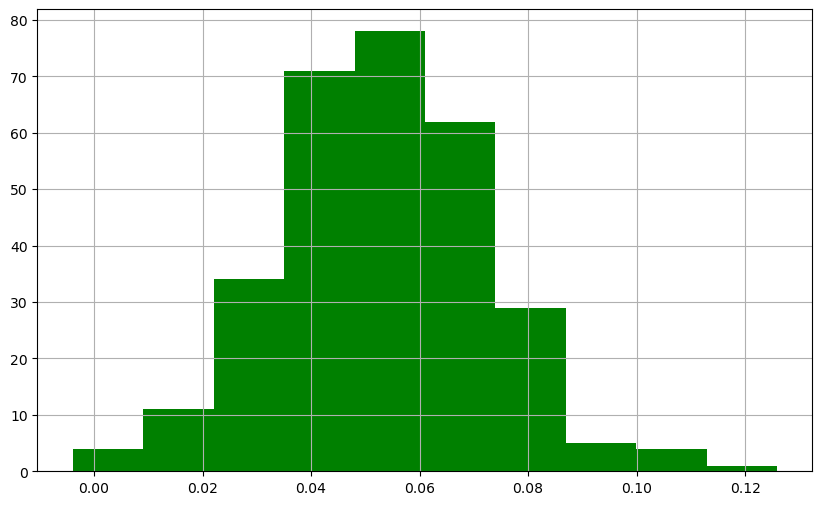

In [14]:
plt.figure(figsize = (10,6))
news_data['Polarity'].hist(color = 'green')

<AxesSubplot:>

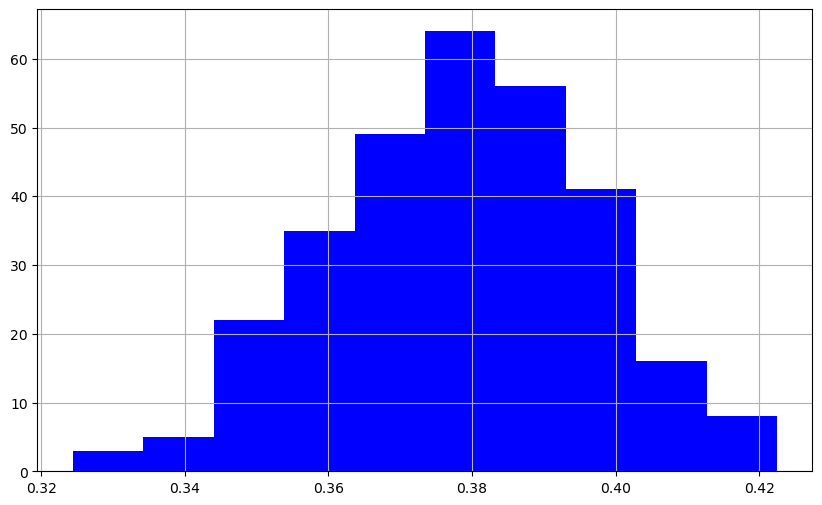

In [15]:
plt.figure(figsize = (10,6))
news_data['Subjectivity'].hist(color = 'blue')

In [16]:
snt = SentimentIntensityAnalyzer()

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [26]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading vader_lexicon: <urlopen error [WinError
[nltk_data]     10060] A connection attempt failed because the
[nltk_data]     connected party did not properly respond after a
[nltk_data]     period of time, or established connection failed
[nltk_data]     because connected host has failed to respond>


False

In [18]:
news_data['Compound'] = [snt.polarity_scores(v)['compound'] for v in news_data['headline_text']]
news_data['Negative'] = [snt.polarity_scores(v)['neg'] for v in news_data['headline_text']]
news_data['Neutral'] = [snt.polarity_scores(v)['neu'] for v in news_data['headline_text']]
news_data['Positive'] = [snt.polarity_scores(v)['pos'] for v in news_data['headline_text']]
news_data

,publish_date,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
7417,2021-06-05,Horoscope Today June Check astrologi...,0.363601,0.045100,-0.9999,0.149,0.761,0.091
7418,2021-06-06,Man beaten to death for murder Rakshit Shetty ...,0.400750,0.019444,-0.9998,0.133,0.787,0.080
7419,2021-06-07,Expert approved techniques for creating natura...,0.355720,0.045619,-0.9999,0.150,0.760,0.089
7420,2021-06-08,Why some women feel guilty about premarital se...,0.383899,0.054865,-0.9998,0.122,0.802,0.076
7421,2021-06-09,Youth held for attempting to rob woman's ornam...,0.390521,0.049587,-0.9987,0.102,0.819,0.079
...,...,...,...,...,...,...,...,...
7711,2022-03-26,Mumbai celebrates World Theatre Day with speci...,0.380259,0.041225,-0.9999,0.168,0.753,0.079
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162,-0.9999,0.158,0.758,0.084
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513,-0.9999,0.160,0.737,0.103
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,-0.9999,0.159,0.755,0.086


In [19]:
df_num = pd.read_csv("C:/Users/Gokul nath/Downloads/HDB (1).csv")
df_num.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-01,78.849998,79.010002,78.320000,78.849998,77.148323,2447400
1,2021-09-02,79.010002,79.169998,78.059998,78.250000,76.561279,2639500
2,2021-09-03,77.610001,78.129997,76.620003,76.639999,74.986023,1167600
3,2021-09-07,76.750000,77.750000,76.440002,77.099998,75.436089,2156200
4,2021-09-08,77.199997,77.400002,76.440002,76.720001,75.064293,919400


In [20]:
df_num["Date"] = pd.to_datetime(df_num["Date"],format='%Y-%m-%d')
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       146 non-null    datetime64[ns]
 1   Open       146 non-null    float64       
 2   High       146 non-null    float64       
 3   Low        146 non-null    float64       
 4   Close      146 non-null    float64       
 5   Adj Close  146 non-null    float64       
 6   Volume     146 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 8.1 KB


In [21]:
df_num.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
141,2022-03-24,60.509998,60.820000,59.970001,60.799999,59.487862,1364000
142,2022-03-25,60.570000,60.910000,60.049999,60.279999,58.979088,1281800
143,2022-03-28,59.869999,60.580002,59.619999,60.270000,58.969307,1323800
144,2022-03-29,61.310001,62.279999,60.869999,61.820000,60.485855,2398200
145,2022-03-30,61.500000,62.040001,61.180000,61.230000,59.908585,1616900


In [22]:
df_num.describe()

,Open,High,Low,Close,Adj Close,Volume
count,146.000000,146.000000,146.000000,146.000000,146.000000,1.460000e+02
mean,68.751233,69.399726,67.963288,68.613698,67.132935,1.726663e+06
std,5.450425,5.327593,5.482908,5.422878,5.305846,7.647896e+05
min,55.169998,56.049999,54.250000,54.480000,53.304256,5.048000e+05
25%,65.219999,65.815003,64.507500,65.077499,63.673051,1.163800e+06
50%,68.669998,69.580002,68.084999,68.700001,67.217372,1.535550e+06
75%,73.072496,73.607500,72.157504,72.722501,71.153066,2.219800e+06
max,79.010002,79.169998,78.320000,78.849998,77.148323,5.057100e+06


In [23]:
df_num.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0, 0.5, 'QMCI')

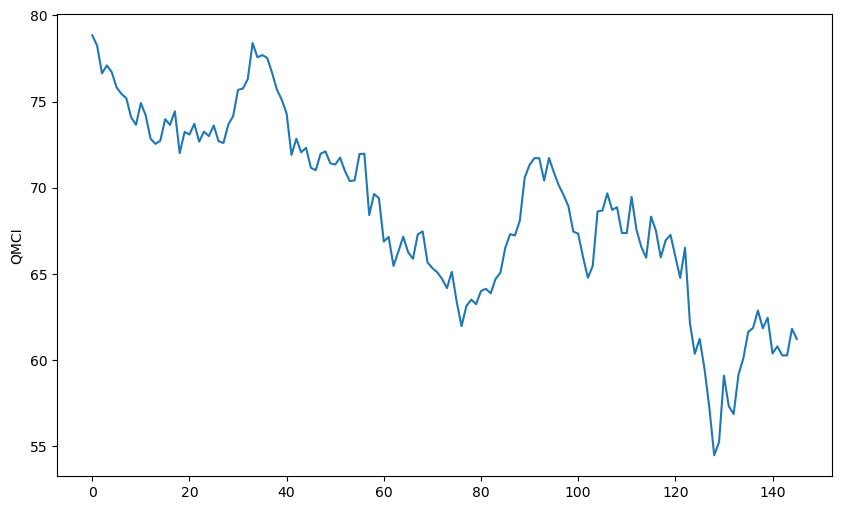

In [24]:
plt.figure(figsize=(10,6))
df_num['Close'].plot()
plt.ylabel('QMCI')

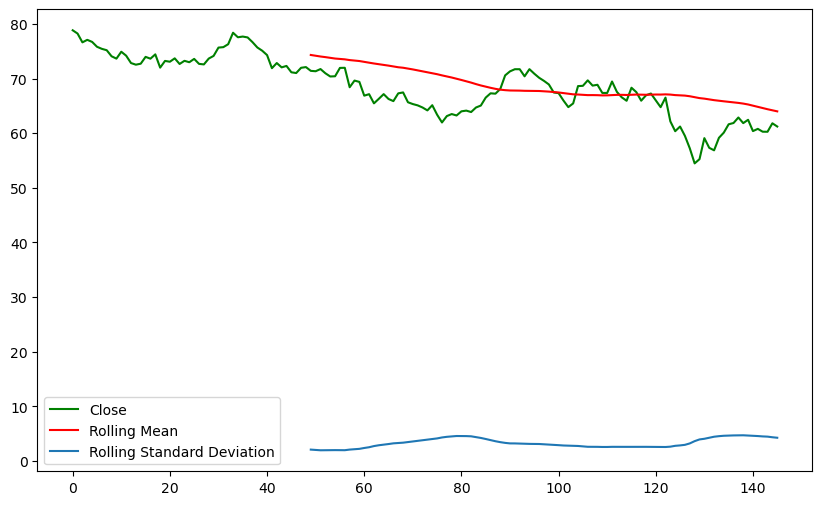

In [25]:
close = df_num['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10,6))
df_num['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

In [26]:
train = df_num[:100]
test = df_num[100:]

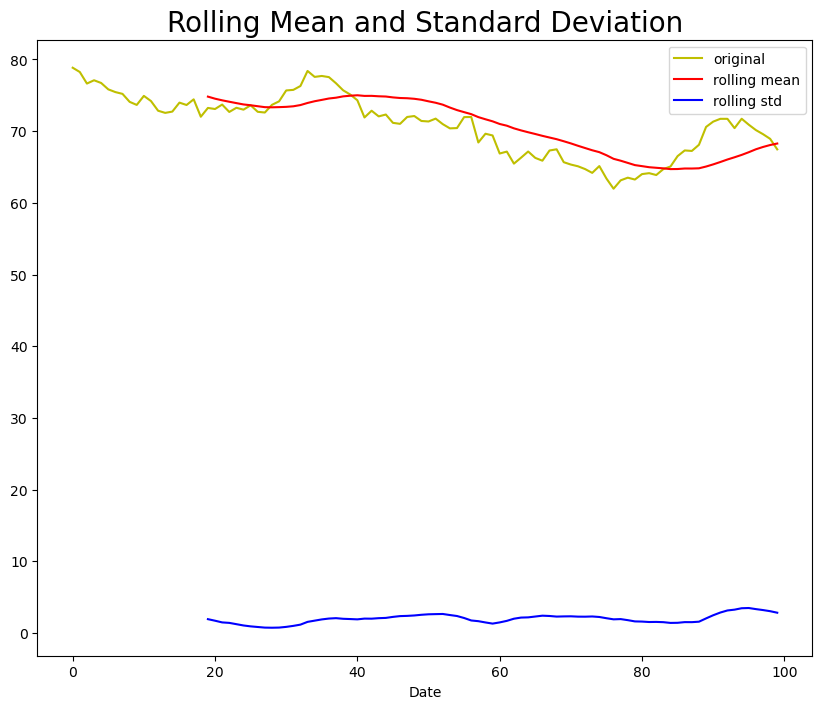

Results of dickey fuller test
ADF Test Statistic : -1.8123994284894012
p-value : 0.3743233295891628
#Lags Used : 0
Number of Observations Used : 99
Weak evidence against null hypothesis, time series is non-stationary 


In [27]:
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

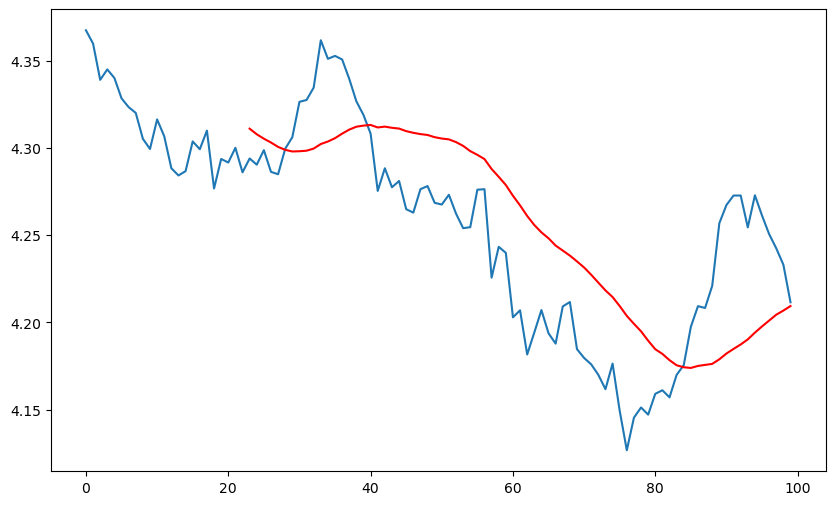

In [28]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

In [29]:
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-554.189, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-551.097, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-549.587, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-549.614, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-551.960, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-549.386, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-546.472, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-550.937, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-553.466, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-547.128, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-555.113, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-551.807, Time=0.13 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-553.524, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-547.606, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept

Text(0, 0.5, 'Actual Stock Price')

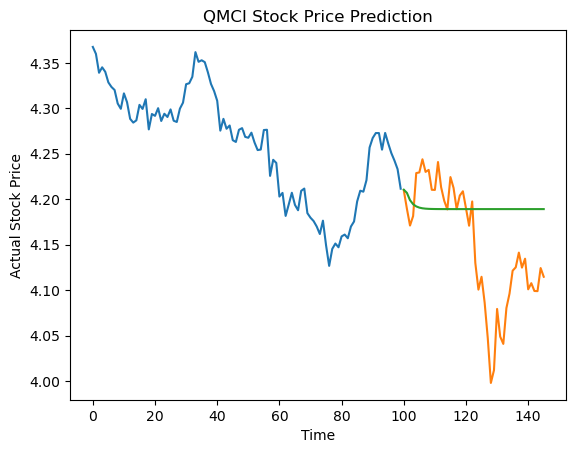

In [30]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('QMCI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [31]:
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.07603151002983054


In [32]:
merge = news_data
merge

,publish_date,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
7417,2021-06-05,Horoscope Today June Check astrologi...,0.363601,0.045100,-0.9999,0.149,0.761,0.091
7418,2021-06-06,Man beaten to death for murder Rakshit Shetty ...,0.400750,0.019444,-0.9998,0.133,0.787,0.080
7419,2021-06-07,Expert approved techniques for creating natura...,0.355720,0.045619,-0.9999,0.150,0.760,0.089
7420,2021-06-08,Why some women feel guilty about premarital se...,0.383899,0.054865,-0.9998,0.122,0.802,0.076
7421,2021-06-09,Youth held for attempting to rob woman's ornam...,0.390521,0.049587,-0.9987,0.102,0.819,0.079
...,...,...,...,...,...,...,...,...
7711,2022-03-26,Mumbai celebrates World Theatre Day with speci...,0.380259,0.041225,-0.9999,0.168,0.753,0.079
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162,-0.9999,0.158,0.758,0.084
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513,-0.9999,0.160,0.737,0.103
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,-0.9999,0.159,0.755,0.086


In [33]:
data = merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
data

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
7417,0.363601,0.045100,-0.9999,0.149,0.761,0.091
7418,0.400750,0.019444,-0.9998,0.133,0.787,0.080
7419,0.355720,0.045619,-0.9999,0.150,0.760,0.089
7420,0.383899,0.054865,-0.9998,0.122,0.802,0.076
7421,0.390521,0.049587,-0.9987,0.102,0.819,0.079
...,...,...,...,...,...,...
7711,0.380259,0.041225,-0.9999,0.168,0.753,0.079
7712,0.365123,0.034162,-0.9999,0.158,0.758,0.084
7713,0.383007,0.058513,-0.9999,0.160,0.737,0.103
7714,0.403627,0.092144,-0.9999,0.159,0.755,0.086


In [34]:
X = data[-146:]
y = df_num['Close']

In [35]:
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
7570,0.411764,0.125908,-0.9944,0.116,0.778,0.106
7571,0.402466,0.059464,-0.9999,0.172,0.731,0.097
7572,0.394223,0.060453,-0.9999,0.169,0.745,0.086
7573,0.399316,0.081662,-0.9997,0.133,0.770,0.097
7574,0.377100,0.069880,-0.9999,0.134,0.790,0.076
...,...,...,...,...,...,...
7711,0.380259,0.041225,-0.9999,0.168,0.753,0.079
7712,0.365123,0.034162,-0.9999,0.158,0.758,0.084
7713,0.383007,0.058513,-0.9999,0.160,0.737,0.103
7714,0.403627,0.092144,-0.9999,0.159,0.755,0.086


In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(116, 6)

In [37]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [38]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[64.5819002  70.68879969 67.6788001  71.41579974 68.08499976 66.01809983
 72.02769999 73.28240065 70.72849895 68.55789911]
7      75.199997
24     73.000000
27     72.599998
119    67.269997
142    60.279999
51     71.750000
43     72.059998
22     72.680000
112    67.570000
26     72.699997
Name: Close, dtype: float64
Mean Squared error:  27.9715838674797


In [39]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

Mean Squared error:  60.281565100672346


In [40]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)
predictions = xgb.predict(x_test)
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

Mean Squared error:  41.30858978887358


In [114]:
from sklearn.neural_network import MLPRegressor

In [115]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=650, random_state=43)

In [116]:
mlp_regressor.fit(x_train, y_train)

# Make predictions on the test data
y_pred = mlp_regressor.predict(x_test)

# Calculate the Mean Squared Error (MSE) to evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse=np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 37.433922411484104
Root Mean Squared Error: 6.118326765667563


In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU

In [74]:
model = Sequential()
model.add(LSTM(50, input_shape=(6, 1), return_sequences=True))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 6, 50)             10400     
                                                                 
 dense_7 (Dense)             (None, 6, 1)              51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
3/3 [==============================] - 2s 349ms/step - loss: 4746.7549 - val_loss: 4596.0093
Epoch 2/10
3/3 [==============================] - 0s 27ms/step - loss: 4744.0874 - val_loss: 4593.2671
Epoch 3/10
3/3 [==============================] - 0s 23ms/step - loss: 4741.2085 - val_loss: 4590.2134
Epoch 4/10
3/3 [==============================] - 0s 25ms/step - loss: 4737.9800 - val_loss: 4586.7280
Epoch 5/10
3/3 [==============================] - 0s 22ms/step - loss: 4734.2539 - val_loss: 4582.6846
Epoch 6/10
3/3 [==============================] - 0s 22ms/step - loss: 4729.9482 - val_loss: 4577.9233
Epoch 7/10
3/3 [==============================] - 0s 21ms/step - loss: 4724.8320 - val_loss: 4572.2441
Epoch 8/10
3/3 [==============================] - 0s 19ms/step - loss: 4718.6943 - val_loss: 4565.3765
Epoch 9/10
3/3 [==============================] - 0s 18ms/step - loss: 4711.2466 - val_loss: 4556.9482
Epoch 10/10
3/3 [==============================] - 0s 20ms/step - loss: 

In [76]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 6, 50)             10400     
                                                                 
 dense_7 (Dense)             (None, 6, 1)              51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
y_predicted = model.predict(x_test)

1/1 [==============================] - 0s 406ms/step


In [78]:
time_window = 10
X_train_reshaped = []
X_test_reshaped = []

In [79]:
for i in range(time_window, len(x_train)):
    X_train_reshaped.append(x_train[i - time_window:i])
for i in range(time_window, len(x_test)):
    X_test_reshaped.append(x_test[i - time_window:i])

In [80]:
X_train_reshaped, X_test_reshaped = np.array(X_train_reshaped), np.array(X_test_reshaped)

In [81]:
model = Sequential()
model.add(LSTM(15, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [82]:
model.fit(X_train_reshaped, y_train[time_window:], epochs=50, batch_size=32)

Epoch 1/50
4/4 [==============================] - 1s 7ms/step - loss: 4710.5435
Epoch 2/50
4/4 [==============================] - 0s 6ms/step - loss: 4699.2212
Epoch 3/50
4/4 [==============================] - 0s 3ms/step - loss: 4687.7812
Epoch 4/50
4/4 [==============================] - 0s 6ms/step - loss: 4675.6333
Epoch 5/50
4/4 [==============================] - 0s 6ms/step - loss: 4662.2822
Epoch 6/50
4/4 [==============================] - 0s 5ms/step - loss: 4647.3599
Epoch 7/50
4/4 [==============================] - 0s 5ms/step - loss: 4630.1099
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 4609.4443
Epoch 9/50
4/4 [==============================] - 0s 5ms/step - loss: 4583.9312
Epoch 10/50
4/4 [==============================] - 0s 6ms/step - loss: 4550.8970
Epoch 11/50
4/4 [==============================] - 0s 6ms/step - loss: 4505.5400
Epoch 12/50
4/4 [==============================] - 0s 5ms/step - loss: 4439.7793
Epoch 13/50
4/4 [====================

In [83]:
predictions = model.predict(X_test_reshaped)

1/1 [==============================] - 0s 128ms/step


In [84]:
predictions

array([[68.823135],
       [68.337395],
       [68.01794 ],
       [68.45653 ],
       [68.76073 ],
       [68.91291 ],
       [68.29829 ],
       [68.19129 ],
       [68.39922 ],
       [68.26926 ],
       [68.36204 ],
       [68.48374 ],
       [68.503456],
       [68.73091 ],
       [68.92393 ],
       [68.69607 ],
       [68.658264],
       [68.241005],
       [68.21429 ],
       [68.33799 ]], dtype=float32)

In [85]:
mse = mean_squared_error(y_test[time_window:], predictions)
rmse=np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 27.72002032556412
Root Mean Squared Error: 5.264980562695756


In [86]:
model1 = Sequential()
model1.add(GRU(15, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mean_squared_error')

In [87]:
model1.fit(X_train_reshaped, y_train[time_window:], epochs=50 , batch_size=32)

Epoch 1/50
4/4 [==============================] - 1s 9ms/step - loss: 4673.9326
Epoch 2/50
4/4 [==============================] - 0s 4ms/step - loss: 4664.3999
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 4654.7578
Epoch 4/50
4/4 [==============================] - 0s 5ms/step - loss: 4645.4624
Epoch 5/50
4/4 [==============================] - 0s 4ms/step - loss: 4636.1128
Epoch 6/50
4/4 [==============================] - 0s 4ms/step - loss: 4626.3789
Epoch 7/50
4/4 [==============================] - 0s 6ms/step - loss: 4616.3086
Epoch 8/50
4/4 [==============================] - 0s 6ms/step - loss: 4606.3955
Epoch 9/50
4/4 [==============================] - 0s 5ms/step - loss: 4596.1880
Epoch 10/50
4/4 [==============================] - 0s 4ms/step - loss: 4585.1206
Epoch 11/50
4/4 [==============================] - 0s 7ms/step - loss: 4572.9453
Epoch 12/50
4/4 [==============================] - 0s 5ms/step - loss: 4559.5459
Epoch 13/50
4/4 [====================

In [88]:
predictions = model1.predict(X_test_reshaped)

1/1 [==============================] - 0s 158ms/step


In [89]:
mse = mean_squared_error(y_test[time_window:], predictions)
rmse=np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Mean Squared Error: {rmse}')

Mean Squared Error: 28.099891410684346
Mean Squared Error: 5.300933069817459


In [99]:
y_test[time_window:]

40     74.309998
78     63.509998
130    59.099998
62     65.470001
71     65.099998
91     71.720001
16     73.650002
54     70.430000
98     68.930000
8      74.089996
89     70.589996
37     76.680000
116    67.519997
84     65.070000
144    61.820000
33     78.400002
143    60.270000
90     71.330002
83     64.709999
105    68.680000
Name: Close, dtype: float64

In [108]:
len(y_test[time_window:])

20